In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from collections import defaultdict
import datetime

import warnings
warnings.filterwarnings('ignore')

In [4]:
def extract_info_cascades(save = False) :
    """
    creates 2 files with information about all the cascades : 
        - infos_cascades : 
            i:n_cascades - mid(int64) - date(pd.DateTime) - u(int32) - n_likes(int32) - n_reposts(int32) - users2(list(int32))
        - user_cascades : 
            i:v(int32) - mids(list(int64)) - Av(int32)

    """

    infos_cascades_times = []

    with open("data/weibo/weibodata/total.txt", 'r') as file :
        count_line = 0 
        mid_cascade = None
        time_cascade = 0
        for line in file:
            
            if count_line % 60000 == 0 : print(f"{count_line//2000}K cascades processed")
        
            if count_line%2 == 0 : #mid - date - user1 - #likes
                l = line.replace('\n', '').split()
                mid_cascade = np.int64(l[0])
                time_cascade = int(datetime.datetime.strptime(l[1], "%Y-%m-%d-%H:%M:%S").timestamp())
                infos_cascades_times.append(l)

            else : # (uid timestamp )*
                curr_cascade = line.replace('\n', '').split()
                users2 = []
                times = []
                for i in range(0, len(curr_cascade), 2) :
                    u = np.int32(curr_cascade[i])
                    tu = int(datetime.datetime.strptime(curr_cascade[i+1], "%Y-%m-%d-%H:%M:%S").timestamp())
                    users2.append(u)
                    times.append(tu - time_cascade)
                    
                infos_cascades_times[-1].append(len(curr_cascade)//2) #adds the number of reposts
                infos_cascades_times[-1].append(users2) 
                infos_cascades_times[-1].append(times) 
                
            count_line+= 1
    print(f"{count_line//2000}K cascades processed")
    
    

    infos_cascades_times = pd.DataFrame(infos_cascades_times, columns = ['mid', 'date', 'User1', '#likes', '#reposts', 'users2', 'times'],)
    infos_cascades_times = infos_cascades_times.astype(dtype={'mid' : np.int64, 'User1' : np.int32, '#likes' : np.int32, '#reposts' : np.int32})
    infos_cascades_times['date'] = pd.to_datetime(infos_cascades_times.date)

    print(f"\ninfos_cascades : \n{infos_cascades_times.dtypes}" )
    print(f"shape : {infos_cascades_times.shape}\n")

    if save:
        infos_cascades_times.to_pickle('data/weibo_preprocessed/infos_cascades_times.pkl')

    return infos_cascades_times

infos_cascades_times = extract_info_cascades(True)
# infos_cascades_times = pd.read_pickle("data/weibo_preprocessed/infos_cascades_times.pkl") 


0K cascades processed
30K cascades processed
60K cascades processed
90K cascades processed
120K cascades processed
150K cascades processed
180K cascades processed
210K cascades processed
232K cascades processed

infos_cascades : 
mid                  int64
date        datetime64[ns]
User1                int32
#likes               int32
#reposts             int32
users2              object
times               object
dtype: object
shape : (232978, 7)



In [5]:
graph_times = infos_cascades_times.sort_values(by='#reposts', ascending=False).iloc[:10].times


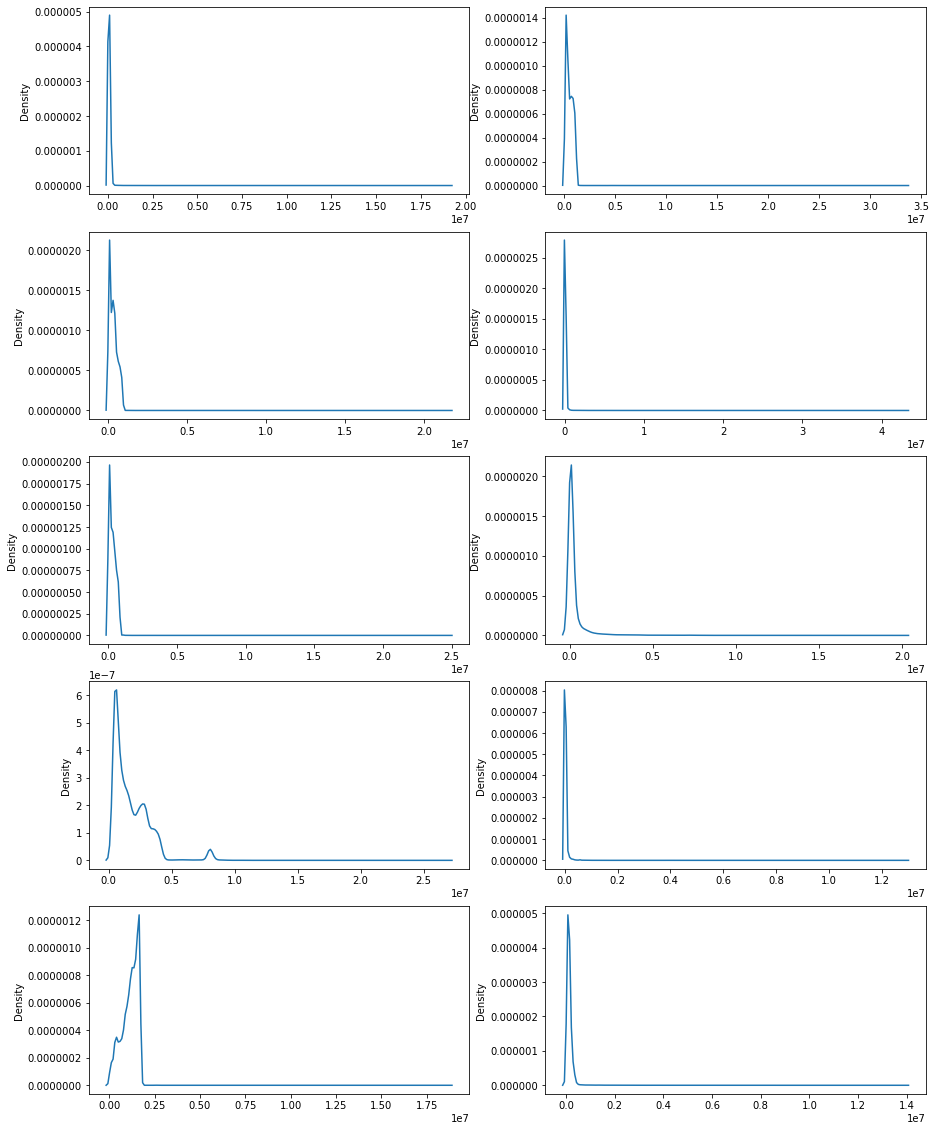

In [16]:
points = []
fig, ax = plt.subplots(5,2, figsize = (15,20))
for i in range(10) : 
    sns.kdeplot(graph_times.iloc[i], ax = ax[i//2][i%2]) 
    
    

In [64]:
n = 200
graph_times = infos_cascades_times.sort_values(by='#reposts', ascending=False).iloc[:n].times

graph_times = graph_times.reset_index()
graph_times['rank'] = graph_times.index
graph_times = graph_times.explode('times')
graph_times['times'] = graph_times.times.apply(lambda x : np.log10(1 + x))

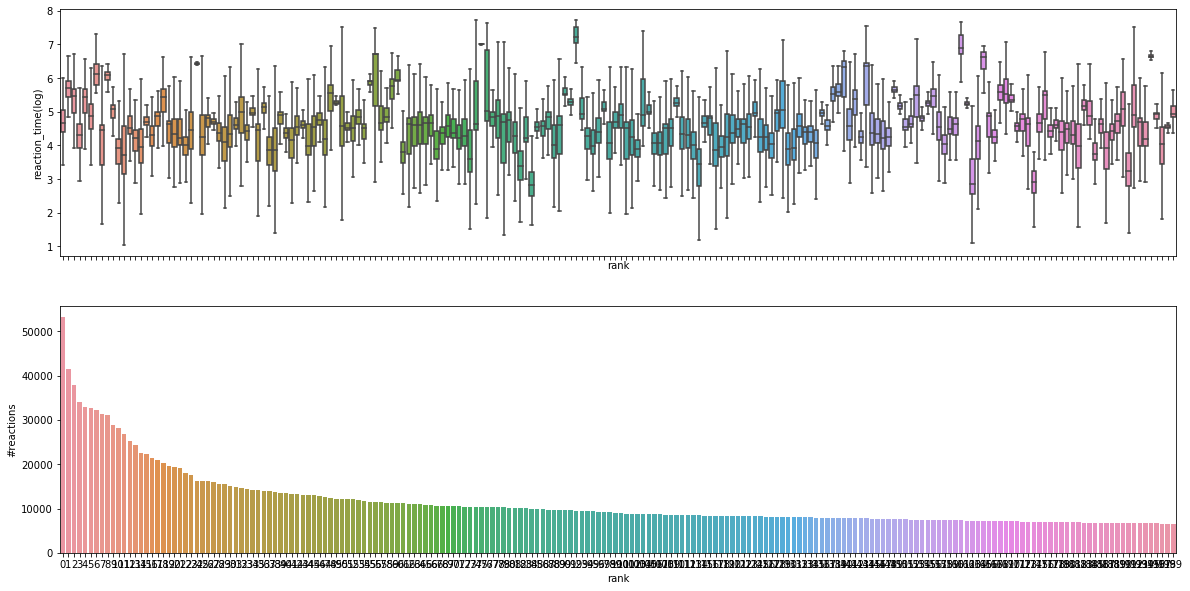

In [65]:
fig, ax = plt.subplots(2,1, figsize = (20,10), sharex=True)

sns.boxplot(data=graph_times, x='rank', y='times', ax=ax[0],showfliers = False)
ax[0].set_ylabel('reaction_time(log)')
sns.countplot(data=graph_times, x='rank', ax=ax[1])
ax[1].set_ylabel('#reactions')
plt.show()

In [61]:
graph_times = infos_cascades_times.sort_values(by='#reposts', ascending=False).iloc[:n].times
np.median(graph_times.apply(lambda x : np.median(np.array(x))))

37371.0

Median of median of reaction times : 37371.0


In [100]:
n = 200
graph_times = infos_cascades_times[['#reposts', 'times']]
graph_times['med'] = graph_times.times.apply(lambda x : np.median(np.array(x)))
graph_times = graph_times.groupby('#reposts').agg({'med' : lambda x : np.median(np.array(x)), 'times' : 'count'})


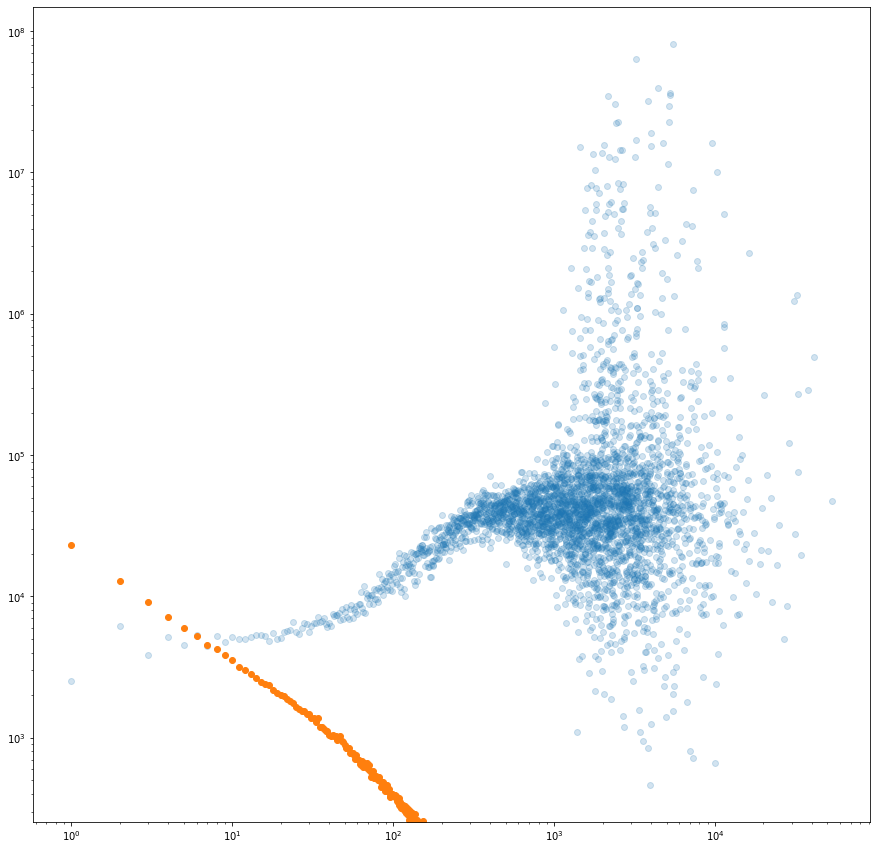

In [102]:
fig, ax = plt.subplots(figsize = (15,15))
ax.scatter(x = graph_times.index, y = graph_times.med, alpha=0.2)
ax.scatter(x = graph_times.index, y = graph_times.times)
ax.set_xscale('log')
ax.set_yscale('log')